# Building Micrograd

[Video](https://www.youtube.com/watch?v=VMj-3S1tku0)<br>
[Repository](https://github.com/karpathy/micrograd)<br>
[Eureka Labs Discord](https://discord.com/invite/3zy8kqD9Cp)

## Table of Contents

- [Goals](#Goals)
- [What is Micrograd](#What-is-Micrograd)
- [Problem Dissection](#Problem-Dissection)
    - [Understanding Derivatives](#Understanding-Derivatives)
    - [Derivatives in Neural Networks](#Derivatives-in-Neural-Networks)
        - [Value Class - Setup](#Value-Class---Setup)
        - [Value Class - Forward](#Value-Class---Forward)
        - [Value Class - Graph Generation](#Value-Class---Graph-Generation)
        - [Quick Recap](#Quick-Recap)
        - [Value Class - Setting up Backpropagation](#Value-Class---Setting-up-Backpropagation)
- [Neural Networks](#Neural-Networks)
    - [Manual Backpropagation](#Manual-Backpropagation)
    - [Automated Backpropagation](#Automated-Backpropagation)
        - [Value Class - Bug Hunting and Extending](#Value-Class---Bug-Hunting-and-Extending)
    - [Everything Comes Together](#Everything-Comes-Together)
- [Doing the exact same thing using the PyTorch API](#Doing-the-exact-same-thing-using-the-PyTorch-API)
- [Back to Neural Networks](#Back-to-Neural-Networks)

In [2]:
import math
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Goals

**This series is about understanding, building and training neural networks from scratch.**<br>
We will cover the very basic understanding all the way up to implementing a fully functional GPT clone.<br>
For a start, we will go over the [micrograd](https://github.com/karpathy/micrograd) project to learn the fundamentals of neural networks.

> **Micrograd is an autograd engine (Automatic Gradient Engine).**<br>
> It contains the essentials for training neural networks in just $150$ lines of code.<br>
> To achieve this, Micrograd implements a process called **backpropagation** *from scratch*.

**What are neural networks?**<br>
Neural networks consist of so-called neurons. Multiple neurons make up a network layer.<br>
Multiple network layers are stacked on top of each other to form a basic neural network.<br>
A neuron may have incoming connections from neurons in the previous layer, and outgoing connections to neurons in the next layer.<br>
These connections may vary in strength. For each of these connections, there is a parameter that defines the strength of the connection. This is called a *weight*.<br>
The neuron calculates the weighted sum of its incoming connections, applies what is called a non-linear function to it, and sends the result to the next layer through its outgoing connections.<br>
This way, generally, basic neural networks take some sort of input data and produce output data by passing the input through its network layers.

**What is backpropagation?**<br>
Neural networks learn from the error they make in their output. *Backpropagation* allows to iteratively tune the network's parameters in such a way that they configure to minimize the difference between the network's own output and a known reference value that should have been attained, i.e. the expected output value.<br>
This way, effectively, backpropagation penalizes the network for output errors.<br>
The penalty changes the network's parameters in a way that the next time the network is given the same input, it will produce an output that is closer to the expectation.

<b>At this point, if any of the above sounds too complicated, [don't worry about it](https://miro.medium.com/v2/resize:fit:1280/1*E4_pTJctmAofSRpZCZbv-g.jpeg).</b><br>
We will approach these concepts in due time, one by one, *from scratch*.<br>
For now, just keep in mind that this *backpropagation* process is at the core of how neural networks learn, and that Micrograd implements this from scratch.

## What is Micrograd?

<b>Autograd engines are *the* core component for training neural networks.</b><br>
Micrograd is a tiny autograd engine that supports automatic differentiation as well as higher-order gradient calculation.<br>
It is just 150 lines of Python code, but it serves as an effective tool for understanding *what* autograd engines are, *what* they do and *how* they work.

Let's start with a simple example using the [original](https://github.com/karpathy/micrograd) Micrograd library:

In [3]:
from micrograd.engine import Value


# Create two "Value" objects, 
# Wrap each around a float number
a = Value(-4.0)
b = Value(2.0)

# Apply arithmetic operations on the "Value" objects
# Create a new "Value" object 'c', override it twice
c = a + b
c += c + 1
c += 1 + c + (-a)

# Prints -1.0, the result of a forward pass through the arithmetic expressions
print(f"Data contained within c:   {c.data:4.1f}")

# Apply Backpropagation (i.e. a backward pass through the expression graph)
# Calculates the gradients for "Value" objects contributing to c (meaning a and b)
c.backward()

# dc/da = 3.0
print(f"Gradient calculated for a: {a.grad:4.1f}")
# dc/db = 4.0; a small change in b would result in a 4.0 times as large change in c
print(f"Gradient calculated for b: {b.grad:4.1f}")

Data contained within c:   -1.0
Gradient calculated for a:  3.0
Gradient calculated for b:  4.0


> **The gradient is a value that indicates the sensitivity of the final result to changes in the affecting values.**<br>
> If we know how much a change in a value affects the final result, we can adjust the value accordingly to shift the final result in the desired direction. This is the core concept behind **backpropagation**.

**Micrograd allows to define numeric values and apply the usual arithmetic operations to these values.**<br>
In the background, Micrograd additionally keeps track of the usages of each value and their contributions to later values as operations progress in a so-called **expression graph**.<br>
This expression graph is then traversed *backwards* to **compute the gradients** resulting from *all* the applied operations.<br>
The goal of autograd engines revolves around correctly, quickly and automatically computing the **gradients** for all kinds of arithmetic operations.

In the above code, `a` and `b` affect `c` through several different operations.<br>
After that, we run `c.backward()` to compute the gradients for `a` and `b` with respect to `c`.<br>
The gradients indicate the sensitivity of the final result `c` to changes in the affecting values `a` and `b`.<br>
For example, a small change in the initial value `b` would result in a $4.0 \times$ as large a change in the final result `c`.

The above example is very basic, but backpropagation can be applied for various arithmetic operations. With Multi-Layered Perceptrons (MLP), a subclass of neural networks, it's a bit more specific. There we have inputs and weights interacting with each other through matrix multiplication and addition.

> Coming back to our explanation of backpropagation above, starting from `c`, the gradient is calculated by recursively applying the [**chain rule**](https://www.khanacademy.org/math/ap-calculus-ab/ab-differentiation-2-new/ab-3-1a/a/chain-rule-review) to all nodes in the expression graph that affect the value of `c`. In that chain of expressions, the way one value affects the next value is captured by the local gradient, which itself is calculated with respect to the local operation it appears in. The chain rule then allows to combine the local gradients with the gradients of the former values in the chain, which is how we can calculate the overall gradient for each value with respect to `c`.


**But what does this mean?**<br>
**What is an expression graph?**<br>
**Why do we use expression graphs?**<br>
**How does the chain rule apply here?**<br>
Let's look at the general problem, step by step.

## Problem Dissection

### Understanding Derivatives

If we want to derive the partial impact of contributing values to some other values, we need to calculate derivatives.<br>
**Derivatives quantify the extent of changes in inputs affecting the outputs.**

Let's start slow; let's implement the arbitrary quadratic function $f(x) = 3x^2-4x+5$ in Python first and play with it:

In [4]:
def f(x):
    # Our example function
    return 3*x**2 - 4*x + 5

# Prints 20.0
f(3.0)

20.0

Let's also plot our example function:

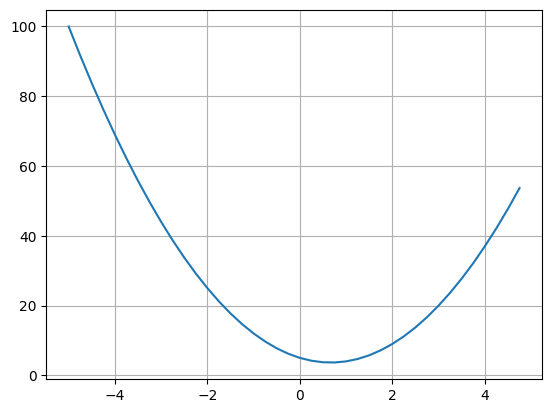

In [5]:
# A range of values from -5 to 5 with step 0.25
xs = np.arange(-5, 5, 0.25)

# Applying y = f(x) to each x
# Collecting all results in ys
ys = f(xs)

# Plotting y for each x
plt.plot(xs, ys)
plt.grid(True)
plt.show();

**Now, what is the derivative at any point $x$ for our function $f(x)$?**<br>
To go about solving this, we should first understand what the derivative is actually telling us about a function $f(x)$.

**This is the textbook definition of what it means for a function $f(x)$ to be differentiable:**<br>
![](https://wikimedia.org/api/rest_v1/media/math/render/svg/aae79a56cdcbc44af1612a50f06169b07f02cbf3)

We're asked to add some positive value $h$ which is close to $0$ to our $a$ to see whether this 'shift from $f(a)$ to $f(a+h)$' increases or decreases
the value returned by the function.<br>
If the value increases between $f(a)$ and $f(a+h)$, the derivative is positive.<br>
If the function decreases, the derivative is negative.

We implement this *verbatim* like so:

In [6]:
h = 0.00000001 # 1e-8
x = 3.0

# Approximate derivative of f at x=3
print((f(x+h)-f(x))/h)

14.00000009255109


This result tells us that the derivative of $f$ with respect to $x$ at $x=3$ can be approximated as $m \approx 14$.<br>
(Calculus of course taught us that the derivative of $f(x) = 3x^2-4x+5$ is $f'(x) = 6x-4$, and $f'(3) = 14$, but we act strictly according to the definition of the approximation here.)

**Let's now increase the complexity with $3$ inputs forming $1$ output:**

In [7]:
a = 2.0
b = -3.0
c = 10.0

d = a * b + c

print(f"a * b + c = {d}")

a * b + c = 4.0


Given the code above, `a * b + c = d` is still a function.<br>
At a first glance, you might think that this function feels 'simpler' than the quadratic function from before.<br>
**But what is the derivative of `d` with respect to `a`, `b` or `c`?**

Let's again take a verbatim approach:

In [8]:
h = 0.00000001 # 1e-8

# This is the point (a, b, c) 
# for which we want the derivative of d
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c # function value at (a, b, c)

a += h       # bump up a by h
d2 = a*b + c # function value at (a+h, b, c)

a -= h       # restore a
b += h       # bump up b by h
d3 = a*b + c # function value at (a, b+h, c)

b -= h       # restore b
c += h       # bump up c by h
d4 = a*b + c # function value at (a, b, c+h)

print('Function value d1 for (a,b,c):\t ', d1)
print('Function value d2 for (a+h,b,c): ', d2)
print('Slope between d2 and d1:\t', (d2 - d1)/h)  # How much the function value increased from bumping up only a by h
print()
print('Function value d3 for (a,b+h,c): ', d3)
print('Slope between d3 and d1:\t ', (d3 - d1)/h) # How much the function value increased from bumping up only b by h
print()
print('Function value d4 of (a,b,c+h):\t ', d4)
print('Slope between d4 and d1:\t ', (d4 - d1)/h) # How much the function value increased from bumping up only c by h

Function value d1 for (a,b,c):	  4.0
Function value d2 for (a+h,b,c):  3.99999997
Slope between d2 and d1:	 -2.999999981767587

Function value d3 for (a,b+h,c):  4.00000002
Slope between d3 and d1:	  1.999999987845058

Function value d4 of (a,b,c+h):	  4.000000010000001
Slope between d4 and d1:	  1.000000082740371


By bumping each input individually by `h`, we can see *how* the value of the original function changes accordingly.

More specifically, we can observe that:
- $(d2 - d1) / h \approx -3.0$, which approximates `b`.
    - The nudge of `a` by `h` scales by `b`, because `f = ab + c` where the value `a` is always scaled by `b`.
- $(d3 - d1) / h \approx 2.0$, which approximates `a`.
    - Changing `b` by `h` scales the output by `a`, because `b` is always scaled by `a` in `f = ab + c` (same logic as above).
- $(d4 - d1) / h \approx 1.0$.
    - Changing `c` by `h` changes the output by exactly `h`, since `c` enters the function additively: `f = ab + c`.
    - The change isn't scaled by any other value (which is the same as saying the change is scaled by `1`).

> **Each slope `(dx - d1) / h` is the partial derivative of `f` with respect to one input having been nudged by `h`:**<br>
> The slope tells us exactly how much the output changes per unit change in one input, holding the others fixed

### Derivatives in Neural Networks

So far, you got a good intuition for what derivatives are and how to calculate them for very simple functions.<br>
You know that the derivative of a function with respect to one of its inputs tells you how much the output changes per unit change in that input, holding the other inputs fixed.<br>
This is the core concept behind backpropagation. Micrograd now implements backpropagation from scratch, which allows us to calculate the derivatives for all kinds of arithmetic operations, including those that are relevant for neural networks. But this has to be done in a general way, which is what we will now look at.

#### Value Class - Setup

We want to move the logic of derivatives over to neural networks.<br>
To achieve this, we first require suitable data structures.

The `Value` class takes a single numeric value and keeps track of it.<br>
You can define values like `a = Value(3.0)` or `b = Value(-2.0)`,<br>
but you then should also be able to perform `a + b` or `a * b` in order to construct a graph of operations and relationships between the indivdual values.<br>
And from this, we finally should be able to find the derivative of the final result with respect to the initial values.

Coming back to the `Value` class, we can define it like so:

In [9]:
class Value:
    
    # Object initialization (constructor)
    def __init__(self, data):
        self.data = data

    # Tells how to print this object nicely  
    def __repr__(self):
        return f"Value(data={self.data})"
    
    # Python-specific operator function for addition, a+b == a.__add__(b)
    def __add__(self, other):
        out = Value(self.data + other.data)
        return out
    
    # Operator function for multiplication
    # For more: https://docs.python.org/3/library/operator.html
    def __mul__(self, other):
        out = Value(self.data * other.data)
        return out

This allows us to use `Value` instances like so already:

In [10]:
a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)

d = a * b + c  # equivalent to a.__mul__(b).__add__(c)

print(d)       # calls d.__repr__(), prints "Value(data=4.0)"
print(d.data)  # the actual numeric value contained within d: 4.0

Value(data=4.0)
4.0


#### Value Class - Forward

Data storage and presentation as well as multiplication and addition are by now accounted for.<br>
But we are still missing a structure for knowing which operations were applied, what the order of application was and which connections between `Value` objects were made through arithmetic operations along the way. **Put differently, we now want to have a way to record *how* specific `Values` produce other `Values` and how they relate to one another.**

We can achieve this tracking capability by adding an attribute `_children` to the `Value` class.<br>
`_children` is an empty `tuple` of `Value` objects that influence the current `Value` object directly.<br>
For example, for `c = a + b`, `c` would have `a` and `b` in its `_children` tuple.

**You may ask yourself why we call the attribute `_children` and not `_parents`.**<br>
It's a design choice, but more importantly it's not a mistake.<br>
The reason is that later on we will traverse the graph backwards, from the result to the inputs.<br>
What technically seems to be the parents during the forward pass through the operations will then be the children during the backward pass.

In [11]:
class Value:
    
    # Constructor now got extended to optionally take the _children tuple
    def __init__(self, data, _children=()):  # _children is a tuple of Values
        self.data = data                     # the actual numeric value contained within this Value object
        self._prev = set(_children)          # _prev is _children but cast to a set for easier processing
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    # Addition, a+b == a.__add__(b)
    def __add__(self, other):
        # We initialize the result's _children to be the Values self and other
        out = Value(self.data + other.data, (self, other))
        return out
    
    # Multiplication, a*b == a.__mul__(b)
    def __mul__(self, other):
        # We initialize the result's _children to be the Values self and other
        out = Value(self.data * other.data, (self, other))
        return out

In [12]:
a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)
d = a * b + c

print(d)        # Value(data=4.0)
print(d._prev)  # {Value(data=-6.0), Value(data=10.0)}

Value(data=4.0)
{Value(data=-6.0), Value(data=10.0)}


We now know the immediate prior `Values`, the `_children`, but we don't know *how* our `Value` was created with these `Value` objects exactly.<br>
To store this information, we further extend our `Value` class.<br>
We add two additional attributes:
- An operations attribute `_op` denoting the operation connecting the `Values` inside `_children`, and
- A label attribute `label` for the graph generation down below.

The `label` attribute is used purely for visualization purposes later on.

In [13]:
class Value:
    
    # Constructor now got extended to optionally take the _children tuple, the _op string and the label string
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    # Addition (a+b == a.__add__(b))
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+') # see the _op argument being set as '+' here
        return out
    
    # Multiplication (a*b == a.__mul__(b))
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out

In [15]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')

e = a*b; e.label='e'
d = e+c; d.label='d'

f = Value(-2.0, label='f')
L = d*f; L.label = 'L'  # L = (a*b+c) * f

print(L)        # Value(data=-8.0)
print(L._prev)  # {Value(data=-2.0), Value(data=4.0)}
print(L._op)    # *

Value(data=-8.0)
{Value(data=-2.0), Value(data=4.0)}
*


#### Value Class - Graph Generation

We can now track that `d` was produced by the addition of two `Values`: `e` and `c`, which got multiplied by `f`. Both `e` and `c` are results of arithmetic operations on other `Values` themselves.<br>
More generally speaking, we can now follow which `Value` was created from which and what that operation looked like, like in a tree making up a final solution node.

**This tree structure can grow quickly. Ideally, we'd like to have a way of visualizing this expression graph.**

The code for that looks a bit scary, but don't worry:

In [16]:
from graphviz import Digraph
# See https://graphviz.readthedocs.io/en/stable/api.html for more on the graphviz library

# Enumerates all the nodes and edges -> builds a set for them
def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

# Draw the graph
def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f }" % (n.label, n.data), shape='record')
        if n._op:
          # if this value is a result of some operation, create an op node for it
          dot.node(name = uid + n._op, label = n._op)
          # and connect this node to it
          dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

And now, just by handing the single final `Value` object `L` of our expression graph to the `draw_dot` function, we can visualize the entire expression graph that is responsible for the value of `L`:

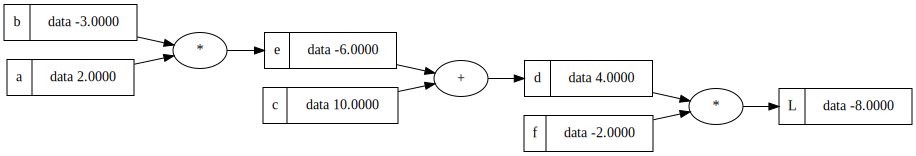

In [17]:
draw_dot(L)

---

### Quick Recap

So far,<br>
- we looked at what derivatives are and how to calculate them for simple functions,
- we looked at partial derivatives for functions with multiple inputs,
- we can **build mathematical expressions** with `Value` objects using $+$ and $*$,
- we can **keep track** of what `Value` objects are interconnected through what operations, resulting in a new `Value` with the `_children` attribute, and the `_op` attribute,
- we can **visualize the expression graph** associated with a resulting root `Value`

> Currently, we only visualize of the **forward pass**.

Next, and most importantly, we need to cover the **backpropagation** process.

---

#### Value Class - Setting up Backpropagation

Let's stick with the above example of how `L` was created.<br>
We start with the *forward pass* result (meaning `L`).<br>
Then, in reverse, we walk along the dependency tree calculating the gradient for the intermediate `Values`.

> In essence, for each `Value`, we calculate the derivative of `L` with respect to this `Value`.

The derivative of `L` with respect to `L` itself is $1$.<br>
Changing `L` has an exactly proportional effect on, well, `L` itself.<br>
This is easy, but what is the derivative of `L` with respect to `f` and so on?<br>
<br>
The derivative of one `Value` (like `L`) with respect to another `Value` that contributes to it (like `f`) is called the **partial derivative**, also known as the **gradient**.

> The **gradient** is the derivative of the loss function with respect to the current `Value`.

For every `Value` the derivative is stored in its attribute `grad`. By default, this attribute is initially set to `0`.<br>
For every arithmetic operation the `Value` participated in, its `grad` attribute will be modified accordingly during backpropagation.

In [18]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0  # gradient of this value, initially 0.0
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    # How we want to print this object
    def __repr__(self):
        return f"Value(data={self.data})"
    
    # Addition (a+b == a.__add__(b))
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        return out
    
    # Multiplication (a*b == a.__mul__(b))
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out
    
    # Tanh function (e^(2x)-1)/(e^(2x)+1)
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        return Value(t, (self, ), 'tanh')

In [19]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label='e'
d = e+c; d.label='d'

f = Value(-2.0, label='f')
L = d*f; L.label = 'L'

print(L)       # Value(data=-8.0)
print(L._prev) # {Value(data=-2.0), Value(data=4.0)}
print(L._op)   # *

Value(data=-8.0)
{Value(data=4.0), Value(data=-2.0)}
*


Let's see what this looks like when visualizing our new `grad` attribute as-is in the graph:

In [20]:
# Enumerates all the nodes and edges -> builds a set for them
def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

# Draw the graph
def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
          # if this value is a result of some operation, create an op node for it
          dot.node(name = uid + n._op, label = n._op)
          # and connect this node to it
          dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

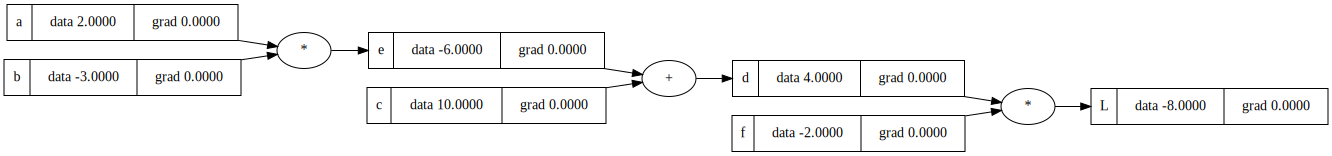

In [21]:
draw_dot(L)

We just built the basic dependency tree visualization with an, as of now, empty `grad` attribute now being visualized as well.<br>
But there is no backpropagation logic yet.

Let's play a little with some ground truth notions about the gradients for our example:

In [22]:
L.grad = 1.0    # The gradient of L w.r.t. itself is always 1.0
d.grad = f.data # As L = d * f, we can be certain that dL/dd = f, as f directly scales changes in d
f.grad = d.data # Because of the above, we can say that dL/df = d, as d respectively scales changes in f

So far, so good. **But now, let's get to the crux of backpropagation.**

> **If you get the next part, you will understand how training neural networks works on a fundamental level.**

To really get to the crux of backpropagation, let's introduce some mathematical notation.<br>
Say, we need to determine the partial derivative of $L$ with respect to $c$, or $\frac{\partial L}{\partial c}$.

Let's also say that we stick to the example calculations from above, meaning:
- $e = a \times b$
- $d = e + c$
- $L = d \times f$

From what we already discussed above for this set of arithmetic operations, we know that `d.grad = f.data`.<br>
Put differently, we know that the partial derivative of $L$ with respect to $d$ is $\frac{\partial L}{\partial d} = f = -2.0$.

I now claim that just from this setting, we can directly say that the *local derivative* of $c$ and $e$ is $1$, respectively.<br>
<br>
**How is that? Why? What?**<br>
The term *local derivative* refers to the immediate operation within which the terms $c$ and $e$ are used, that being $d = c + e$.<br>
Intuitively, a change of any particular size to $c$ or $e$ impacts $d$ with that exact same size.<br>
ThereforeFrom what we already discussed above, we can say that `d.grad = f.data`.<br>
This means that the partial derivative of $L$ with respect to $d$ is **known already:** $\frac{\partial L}{\partial d} = f = -2.0$.

I will now go ahead and claim that just from this setting, *we can directly say* that not the partial derivative, but the *local derivative* of $c$ and $e$ is $1$, respectively.<br>
<br>
**How? Why? What?** The term *local derivative* refers to the immediate operation within which the terms $c$ and $e$ are used, that being $d = c + e$.<br>
Intuitively, a change of a particular size to $c$ or $e$ impacts $d$ with the exact same size, unaffected by scaling through the other participating value, as they are connected arithmetically through summation, not multiplication.<br>
Therefore the *local derivative*, the 'impact factor of change' so to say, is $1$ for both $c$ and $e$:

$\frac{\partial d}{\partial c} = 1.0$<br>
$\frac{\partial d}{\partial e} = 1.0$

As our goal is to find $\frac{\partial L}{\partial c}$, we need to *somehow* concatenate the known intermediary result $\frac{\partial L}{\partial d}$<br>
with our newly found local derivatives $\frac{\partial d}{\partial c}$ and $\frac{\partial d}{\partial e}$ to formulate $\frac{\partial L}{\partial c}$ and $\frac{\partial L}{\partial e}$.

**This is a job for the chain rule of calculus.**

The chain rule looks like this:<br>
![](https://wikimedia.org/api/rest_v1/media/math/render/svg/e1a610aa8446be002e2e30d7121f6a87273d4caa)

It states that the derivative of a function $f$ with respect to $x$ can be calculated by multiplying the derivative of $f$ with respect to an intermediate variable $u$ with the derivative of $u$ with respect to $x$.<br>
This is exactly what applies to our case. We can use this to combine the information from local derivatives with the known partial derivative of $L$ with respect to $d$ to calculate the partial derivative of $L$ with respect to $c$ and $e$.

Curiously, $\frac{\partial d}{\partial c}$ turns out to have no effect on the final result $\frac{\partial L}{\partial c}$, as it's just $1.0$.<br>
Same goes for $\frac{\partial d}{\partial e}$ and its impact on $\frac{\partial L}{\partial e}$.

> As the additively combined values $c$ and $e$ have the *local derivatives* $1.0$, we can see that the addition operation routes the gradient equally down to the values that were summed. In other words, **addition evenly distributes the gradient we accumulated until that point to the summands.**

Finally, we can say that $c$ and $e$ relate to $L$ with the following partial derivatives:<br>
$\frac{\partial L}{\partial c} = \frac{\partial L}{\partial d} \times \frac{\partial d}{\partial c} = -2.0 \times 1.0 = \frac{\partial L}{\partial d} = \underline{\underline{-2.0}}$<br>
$\frac{\partial L}{\partial e} = \frac{\partial L}{\partial d} \times \frac{\partial d}{\partial e} = -2.0 \times 1.0 = \frac{\partial L}{\partial d} = \underline{\underline{-2.0}}$

Stepping further up the dependency tree, we see that $e$ is made up of $a$ and $b$ through $e = a \times b$.<br>
Now we actually have to deal with multiplication.<br>

With the prior step, we learnt that $\frac{\partial L}{\partial e} = -2.0$.<br>
Now, again, we start by formulating the *local derivatives*: $\frac{\partial e}{\partial a}$ and $\frac{\partial e}{\partial b}$.

From looking at $e = a \times b$, we can see that $\frac{\partial e}{\partial a} = b = -3.0$ and $\frac{\partial e}{\partial b} = a = 2.0$.

> The scale by which a change of either of the two factors affects the result is defined entirely by the other factor.

With that insight, we can again use the chain rule to calculate $\frac{\partial L}{\partial a}$ and $\frac{\partial L}{\partial b}$ like so:<br>
$\frac{\partial L}{\partial a} = \frac{\partial L}{\partial e} \times \frac{\partial e}{\partial a} = -2.0 \times -3.0 = \underline{\underline{6.0}}$<br>
$\frac{\partial L}{\partial b} = \frac{\partial L}{\partial e} \times \frac{\partial e}{\partial b} = -2.0 \times 2.0 = \underline{\underline{-4.0}}$

Bringing our results for $\frac{\partial L}{\partial a}$, $\frac{\partial L}{\partial b}$, $\frac{\partial L}{\partial c}$ and $\frac{\partial L}{\partial e}$ together, we could now go ahead and fill out the `grad` attributes for all `Value` objects in our graph like so:

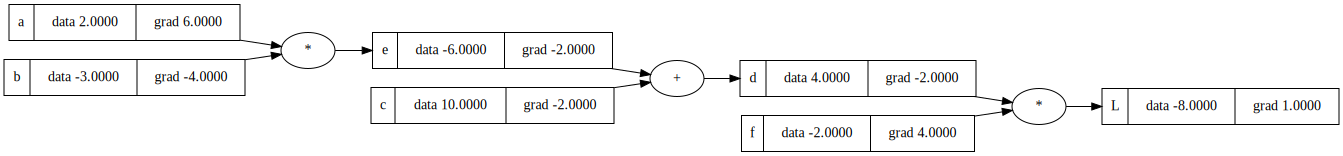

In [23]:
# Gradients from summation of c and e to d
c.grad = d.grad * (1) # dL/dc = dL/dd * dd/dc = dL/dd * 1
e.grad = d.grad * (1) # dL/de = dL/dd * dd/de = dL/dd * 1

# Gradients from multiplication of a and b to e
a.grad = e.grad * b.data # dL/da = dL/de * de/da = dL/de * b
b.grad = e.grad * a.data # dL/db = dL/de * de/db = dL/de * a

draw_dot(L)

Let's look at how `L` changes when updating all the contributing variables along their respective gradient by just a small amount:

In [24]:
# Moving leaf nodes in gradient direction
# This is gradient ascent (the opposite of gradient descent)
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

# Forward pass
e = a * b
d = e + c
L = d * f

print(L.data) # L increased

-7.286496


**Why did we see an increase of `L`?**

The gradient always points in the direction of the **steepest ascent**.<br>
<br>
Moving a value in the direction of the gradient will provide a biggest possible effect of increase on `L` through this contributing value.<br>
Moving all values along their gradient direction will maximize `L`.<br>
**Moving all values in the exact opposite/negative direction of their gradient therefore will minimize `L`.**

**Notice how we haven't yet automated the backpropagation process.**<br>
We had to calculate the gradients manually and then update the contributing values manually as well.<br>
But we know how this works now. There's just a little more to automating this process, which we will now look at in the applied context of neural networks. Once we do that, we can tie everything together and see how the entire process of backpropagation can be implemented in just a few lines of code.

## Neural Networks

Until now, we have looked at building expression graphs for simple functions and we covered how to calculate the gradients for all contributing values in that graph through backpropagation, i.e. through applying the concepts of both local and partial derivatives and relating them through the chain rule.<br>
**Now, let's take these concepts of forward pass and backpropagation and apply them to neural networks.**<br>
**This will be one more manual iteration before we automate our gradient calculation for micrograd.**

Eventually, we want to build working neural networks (NNs) like this very simple one:<br>
![](https://cs231n.github.io/assets/nn1/neural_net2.jpeg)

For a start, we should have a look at the mathematical model defining a neuron inside the neural network:<br>
![](https://cs231n.github.io/assets/nn1/neuron_model.jpeg)

**There is this term 'activation function' appearing in the image.**<br>
The activation function, also called non-linearity, gets applied to the weighted sum of the inputs to our neuron.<br>
This activated value then gets passed on as input from our neuron to the next layer's weighted connections.<br>
There exist different activation functions with different properties. For example, the above one is called `tanh`.<br>
More generally speaking, **introducing an activation function like `tanh` to the neurons of a neural network allows said network to learn/optimize for more complex, *non-linear* relationships from the input data.**<br>
To achieve this, the activation function effectively maps the weighted sum of the inputs to a value of a different range.<br>
<br>
For reference, here is what the two activation functions `tanh` and `sigmoid` look like:

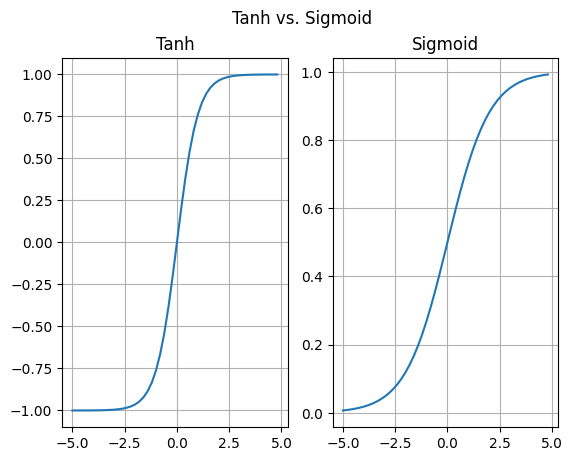

In [25]:
def sigmoid(x):
    a = []
    for i in x:
        a.append(1/(1+math.exp(-i)))
    return a

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Tanh vs. Sigmoid')

lower = -5
upper = 5
step = 0.2

ax1.grid()
ax1.set_title('Tanh')
ax1.plot(np.arange(lower, upper, step), np.tanh(np.arange(-5, 5, 0.2))) # Tanh activation function
ax2.grid()
ax2.set_title('Sigmoid')
ax2.plot(np.arange(lower, upper, step), sigmoid(np.arange(-5, 5, 0.2))) # Sigmoid activation function (alternative)

plt.show();

The `tanh` function maps its numeric input into a range $[-1,1]$, while the `sigmoid` function's output range is $[0,1]$.<br>
For our example, we will be using `tanh` as the neuron activation function.

Let's go ahead and build a tiny MLP by implementing $\text{tanh}(\sum_{i=1}^{n} w_ix_i + b)$ for $n=2$ inputs:

In [37]:
# Inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# Weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# Bias b
# Making sure backprop numbers come out nice later on
b = Value(6.8813735870195432, label='b')

# Neuron value m: x1w1+x2w2 + b
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1*w1 + x2*w2'
m = x1w1x2w2 + b; m.label='m'

# Squashed activation o: tanh(m)
o = m.tanh(); o.label='o'

We effectively implemented this exact neuron:<br>
![](./img/mlp_2_inp.png)

We can now draw the dependency graph for this neuron's output `o`:

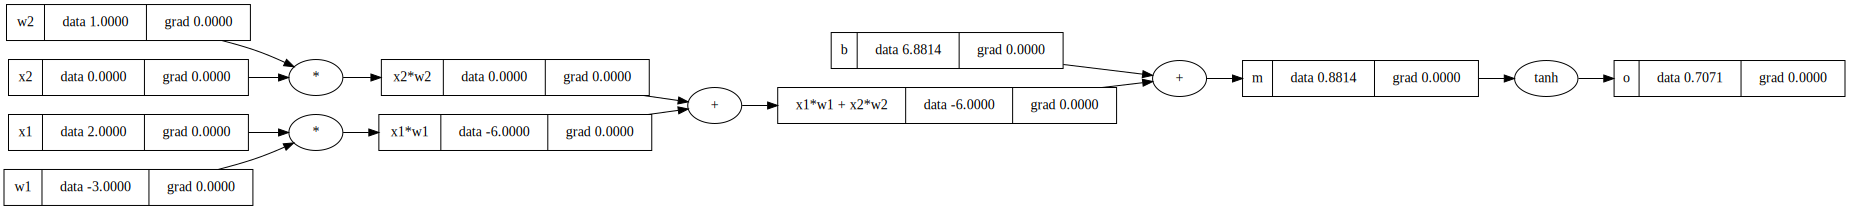

In [38]:
draw_dot(o)

### Manual Backpropagation

We've already seen and talked through the ground rules to backpropagation.<br>
Now, let's perform manual backpropagation for this neuron: Starting from `o` and going backwards, we want to find *all* the gradients for the contributing variables.

> By the end, we will be able to answer what the derivative of `o` is with respect to either `x1`, `w1`, `x2`, or `w2`.

The gradient of the activated root value `o` with respect to itself is always $1.0$, as we've seen in our earlier example.<br>
But what about the gradient of `o` with respect to the weighted sum `m`, i.e. $\frac{\partial o}{\partial m}$?<br>
This is where we have to backpropagate through the activation function `tanh`.

**The local derivative of `tanh` is defined as $1 - \text{tanh}^2(m)$.**<br>
With that, we can finally start propagating backwards:

In [39]:
# Always a given
o.grad = 1.0

# Q: o = tanh(m), what is do/dm?
# A: do/dm = 1 - tanh(m)**2, with o = tanh(m) from the forward pass
m.grad = (1 - o.data**2) * o.grad  # (times o.grad just to show the chain rule; it's not necessary)

# Q: m = x1w1x2w2 + b, what are do/dx1w1x2w2 and do/db?
# A: As the derivative from an addition is just 1.0, it splits the gradient from the chain rule
#    We can effectively pass this chained-on gradient from m on to x1w1x2w2 and b this way
x1w1x2w2.grad = 1.0 * m.grad 
b.grad = 1.0 * m.grad

# Q: x1w1x2w2 = x1w1 + x2w2, what are do/dx1w1 and do/dx2w2?
# A: Once again, addition splits the gradient from x1w1x2w2 via chain rule; we can just pass it on
x1w1.grad = 1.0 * x1w1x2w2.grad
x2w2.grad = 1.0 * x1w1x2w2.grad

# Q: x1w1 = x1*w1, what are do/dx1 and do/dw1?
# A: Multiplication is that little bit more complex, we apply the product rule
#    as w1 * x1, w1 is the local derivative for x1, and x1 is the local derivative for w1
#    We link the local derivatives to x1w1's gradient through the chain rule
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

# Q: x2w2 = x2*w2, what are do/dx2 and do/dw2?
# A: Again, same application of the product rule as above for x1, w1
#    And again, we link the local derivatives to x2w2's gradient accordingly
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad # This will become 0; Changing w2 has no effect, as x2 is 0 and multiplying with w2

### Automated Backpropagation

**Doing backprop manually is amateur-hour.**<br>
We shall automate and generalize.

To do so, we need to considerably re-write and extend the `Value` class.<br>
More precisely, we have to extend `Value` objects by a `_backward` attribute, which we can implement as a [lambda expression](https://www.bomberbot.com/python/lambda-expressions-in-python-a-comprehensive-guide/) initialized with `None`.<br>
For each operation, `_backward` is populated with a concrete gradient calculation step.

This revised `Value` class below realizes this concept very beautifully:

In [42]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0                # Gradient of this Value, initially 0.0 
        self._backward = lambda: None  # Doing nothing by default, holds function by which to backprop grads up to _children
        self._prev = set(_children)    # Contributing _children Values, cast to set
        self._op = _op                 # Operator that produced this Value
        self.label = label             # Label for graphviz
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    # Addition (a+b == a.__add__(b))
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            # Route gradient coming from out to self and other
            # Addition has local derivative of 1.0 for both
            # Link the local derivatives to out's gradient via chain rule
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad

        out._backward = _backward # Set grad calculation behavior as lambda expression
        return out
     
    # Multiplication (a*b == a.__mul__(b))
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            # Route gradient coming from out to self and other
            # Multiplication has local derivative of other.data for self.grad, and self.data for other.grad
            # Respectively, again, linked up to out's gradient via chain rule
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad
        
        out._backward = _backward
        return out
    
    # Tanh activation function gets treated kind of like its own operation
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            # Local tanh derivative times gradient coming in from child Value
            self.grad = (1 - t**2) * out.grad
        
        out._backward = _backward
        return out

In [43]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label='e'
d = e+c; d.label='d'

f = Value(-2.0, label='f')
L = d*f; L.label = 'L'

print(L)       # Value(data=-8.0)
print(L._prev) # {Value(data=-2.0), Value(data=4.0)}
print(L._op)   # *

Value(data=-8.0)
{Value(data=-2.0), Value(data=4.0)}
*


Let's now go on and 'forward pass' through our simple MLP from earlier with this new `Value` class:

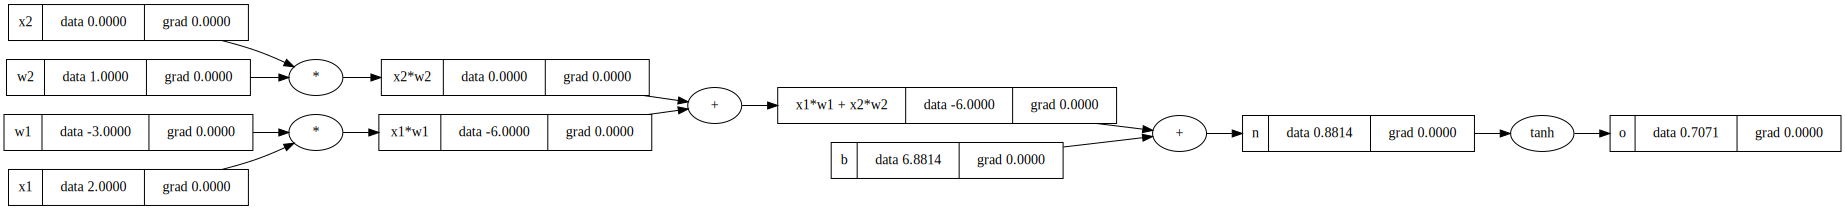

In [46]:
# Inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# Weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# Bias
b = Value(6.8813735870195432, label='b') # Making sure backprop numbers come out nice later on

## Forward Pass 
# Goal: Find the value of the single output neuron 'n'
# Neuron value n = x1*w1+x2*w2 + b
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label='n'

# Squashed activation: tanh(n)
o = n.tanh(); o.label='o'

draw_dot(o)

Finally, we don't have to perform backpropagation manually anymore (except for the always same `o.grad`, please ignore that).<br>
Keep the exact order of operations in mind for the backward pass:

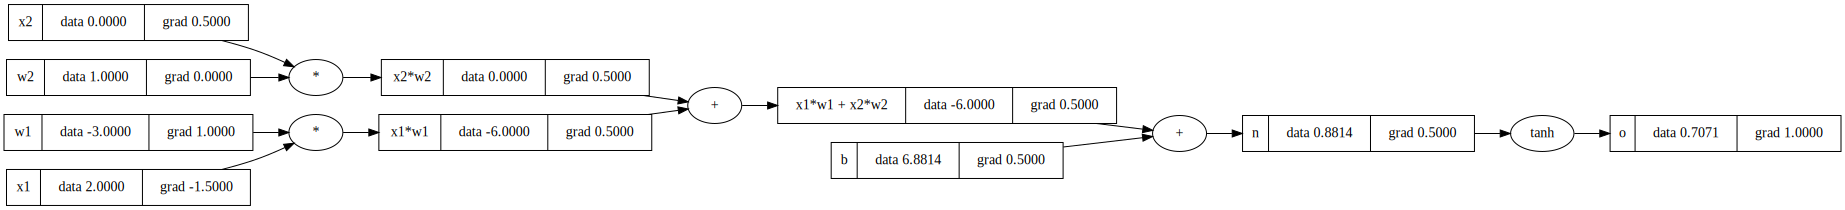

In [51]:
o.grad = 1.0  # Base case for backprop multiplication to work
o._backward()
n._backward()
# b._backward()  # Bias term b doesn't propagate to any higher Value, it's just a leaf node, so no need to run this
x1w1x2w2._backward()
x2w2._backward()
x1w1._backward()
# x1._backward() # Don't need to run these, same reason as for b above
# w1._backward()
# x2._backward()
# w2._backward()

draw_dot(o)

**We now have one last thing to get rid of:** Having to call `_backward()` manually in this particular, tedious, reversed order of appearance of our `Value` calculations.

Going backwards through our expression graph means that for every node in the graph, everything following it has to already be calculated.<br>
*This requires order.* **To establish an order for nodes of a graph, we can use topological sort**.<br><br>
Topological sort arranges the nodes of our dependency graph so that edges always point in *one common direction*:<br>
![](https://assets.leetcode.com/users/images/63bd7ad6-403c-42f1-b8bb-2ea41e42af9a_1613794080.8115625.png)

The ordering induced by topological sort guarantees that gradients are computed and propagated in a manner that avoids redundant computations and maximizes computational parallelism.<br>
This in turn results in improved efficiency through a most seamless flow of gradients through the network and thus accelerated processing and convergence rates. [Read More On Topological Sort...](https://www.geeksforgeeks.org/topological-sorting/)

In [ ]:
# Topological Sort
# Structuring a graph so that we can traverse it in a dependency-respecting order

topo = []
visited = set()

def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v) # Only add node if all preceeding nodes were processed first

build_topo(o)

for t in topo:
    print(f'{t.label:13} : {t}')

w2            : Value(data=1.0)
x2            : Value(data=0.0)
x2*w2         : Value(data=0.0)
x1            : Value(data=2.0)
w1            : Value(data=-3.0)
x1*w1         : Value(data=-6.0)
x1*w1 + x2*w2 : Value(data=-6.0)
b             : Value(data=6.881373587019543)
n             : Value(data=0.8813735870195432)
o             : Value(data=0.7071067811865476)


This is the *exact* order by which we would have to apply `_backward()` to our graph, starting from the root `o`.

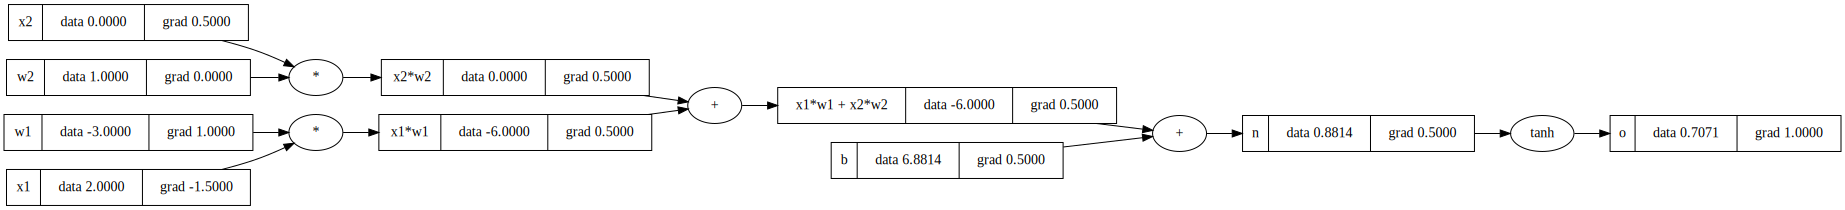

In [67]:
o.grad = 1.0

topo = []
visited = set()

def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v) # Only add node if all nodes were processed first
build_topo(o)

for node in reversed(topo):
    node._backward()

draw_dot(o)

We now go on and implement this topological sorting logic into our `Value` class.<br>
**This is the updated `Value` class structure:**

In [68]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0                # Gradient of this Value, initially 0.0 
        self._backward = lambda: None  # Doing nothing by default, holds function by which to backprop grads up to _children
        self._prev = set(_children)    # Contributing _children Values, cast to set
        self._op = _op                 # Operator that produced this Value
        self.label = label             # Label for graphviz
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    # Addition (a+b == a.__add__(b))
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad
        
        out._backward = _backward
        return out
    
    # Multiplication (a*b == a.__mul__(b))
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad = out.grad * other.data
            other.grad = out.grad * self.data
        
        out._backward = _backward
        return out
    
    # Tanh activation function
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad = (1 - t**2) * out.grad
        
        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v) # Add this node if all children were processed first
        
        # Build topological ordering of all Values in the computation graph upstream of / causing this Value
        build_topo(self)
        
        self.grad = 1.0 # The gradient of the root node is always 1.0
        
        for node in reversed(topo):
            # Go through all Values in reverse topological order,
            # Apply their chain rule to populate the .grad property of each Value
            # This would override the above self.grad = 1.0 if current Value is not root node
            node._backward()

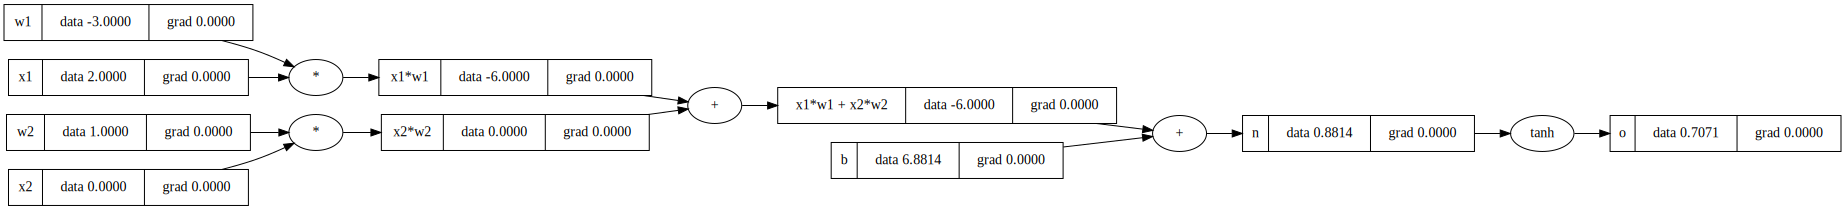

In [69]:
# Inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# Weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# Bias b
b = Value(6.8813735870195432, label='b') # Making sure backprop numbers come out nice later on

# Forward Pass
# Neuron value n: x1w1+x2w2 + b
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label='n'

# Squashed activation o: tanh(n)
o = n.tanh(); o.label='o'

draw_dot(o)

And now we can just call `o.backward()` and the entire backpropagation process will be executed automatically,<br>
without us having to worry about the order of operations at all for our simple MLP:

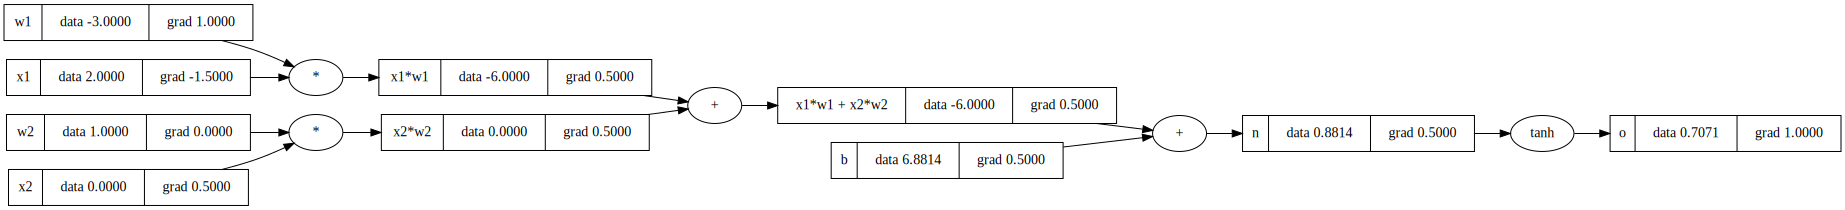

In [70]:
o.backward()
draw_dot(o)

#### Value Class - Bug Hunting and Extending

We just built backpropagation. At least for *one* neuron `o` in a simple single-neuron setting.<br>**But there is still a quite major bug.** 

The bug emerges with this simple example:

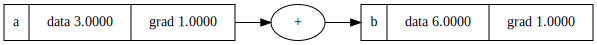

In [71]:
a = Value(3.0, label='a')
b = a + a; b.label = 'b'
b.backward()
draw_dot(b)

Even though we apply addition the gradient should be $2$, because `a + a` is the same as `2 * a`.<br>
**The faulty behavior persists here too:**

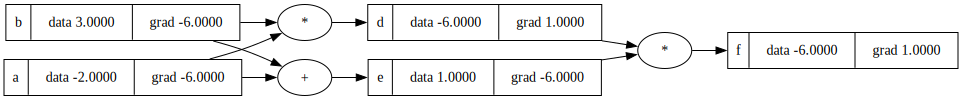

In [29]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b; d.label='d'
e = a + b; e.label='e'
f = d * e; f.label='f'

f.backward()
draw_dot(f)

**We have a consistency problem as soon as a `Value` gets used more than once within the dependency graph.**<br>
But this is the case most of the time in real-world examples.

> **We actually need to *accumulate* the gradients (`+=`) rather than *setting/overriding* them (`=`) inside the `_backward` functions**.

Also, *while we're at it*, let's extend the `Value` class further.<br>
For example, we can't do `a = Value(2.0) + 1.0` or `a = Value(2.0) * 2.0`.<br>
And also, let's integrate division and the detailed operations behind `tanh` now too.

A fixed and extended version of the `Value` class looks like this (see the backward-functions for the `+=` bugfix):

In [72]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None # Does nothing by default
        self._prev = set(_children)
        self._op = _op
        self.label = label
            
    def __repr__(self):
        return f"Value(data={self.data})"
    
    # Addition (a+b == a.__add__(b))
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other) # Extension
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad  # Bugfix
            other.grad += 1.0 * out.grad # Bugfix
        
        out._backward = _backward
        return out
 
    # Multiplication (a*b == a.__mul__(b))
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other) # Extension
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += out.grad * other.data # Bugfix
            other.grad += out.grad * self.data # Bugfix
        
        out._backward = _backward
        return out
    
    # Negation (treat as special multiplication)
    def __neg__(self): # -self
        return -1 * self
    
    # Subtraction (treat as special addition)
    def __sub__(self, other): # self - other
        return self + (-other)

    # Power (treat as special multiplication)
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers (for now)"
        out = Value(self.data ** other, (self,), f'**{other}')
        
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        
        out._backward = _backward
        return out
    
    # Called if self is on right side of *
    def __rmul__(self, other): # other * self
        return self * other
    
    # Called if self is on right side of +
    def __radd__(self, other): # other + self
        return self + other
    
    # True division (treat as special multiplication)
    def __truediv__(self, other): # self / other
        return self * other**-1
    
    # Tanh activation function
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad # Bugfix
        
        out._backward = _backward
        return out
    
    # Exponential function
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
    
        def _backward():
            self.grad += out.data * out.grad
        
        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v) # Only add node if all nodes were processed first
        build_topo(self)
        
        self.grad = 1.0 # Seed gradient always 1.0
        
        for node in reversed(topo):
            node._backward()

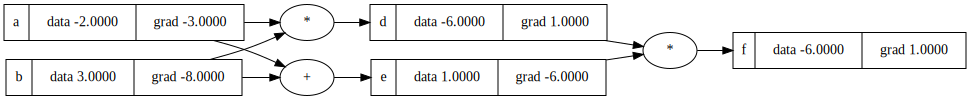

In [73]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b; d.label='d'
e = a + b; e.label='e'
f = d * e; f.label='f'

f.backward()
draw_dot(f)

In [76]:
# Sanity check for the newly implemented arithmetic operations

a = Value(2.0)
b = Value(4.0)

print(a + 2)
print(2 + a)
print(a * 2)
print(2 * a)
print(-a)
print(a - b)
print()
print(a.exp())
print(a / b) # Division: a/b = a * (1/b) = a * (b**(-1)), so we use a function realizing x**k

Value(data=4.0)
Value(data=4.0)
Value(data=4.0)
Value(data=4.0)
Value(data=-2.0)
Value(data=-2.0)

Value(data=7.38905609893065)
Value(data=0.5)


### Everything Comes Together

We will now move on from the single-neuron example we had used throughout the above examples.<br>
More precisely, we will change how we define `o` using the now available, detailed forward and backprop operations for `tanh`.

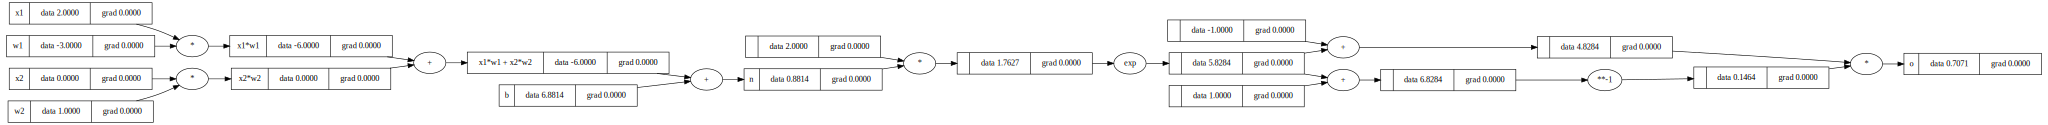

In [77]:
# Inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# Weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# Bias b
b = Value(6.8813735870195432, label='b') # Making sure backprop numbers come out nice later on

# Neuron value n: x1w1+x2w2 + b
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label='n'

# Squashed activation o: tanh(n) NOW EXPLICITLY IMPLEMENTED
e = (2*n).exp()
o = (e - 1)/(e + 1); o.label='o'

draw_dot(o)

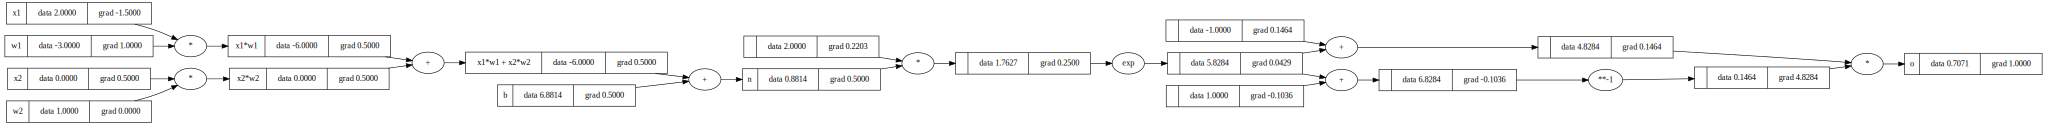

In [78]:
# The x1, x2,... gradients should remain the same
o.backward()
draw_dot(o)

**Why did we do what we just did?**<br><br>
We essentially went ahead and changed the level of implementation in this run.<br><br>
It is up to us if we want to just implement one `tanh` or if we go on and implement that function's atomic steps explicitly using `Value` objects.<br>
By now, it is probably very clear that building this simple autograd engine has primarily been an exercise in handling arithmetic operations, shifting between levels of abstraction in our implementation as it evolved, and ultimately correctly deriving the gradients needed for backpropagation with some robustness.<br>
**We have built the foundation for training neural networks!**

---

## Doing the exact same thing using the PyTorch API

The [original micrograd project](https://github.com/karpathy/micrograd) is modeled roughtly after the PyTorch syntax.<br>
In fact, it's core logic can just as well be implemented in PyTorch.<br>
This Pytorch-native approach we will now get into might seem a bit messy at first, because it requires values to be stored in PyTorch Tensor objects.

In [ ]:
x1 = torch.Tensor([2.0]).double();  x1.requires_grad = True  # single element tensors
x2 = torch.Tensor([0.0]).double();  x2.requires_grad = True  # tensor datatype is now double
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True  # default dtype was float32
w2 = torch.Tensor([1.0]).double();  w2.requires_grad = True  # now its float64 aka double
b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True

n = x1*w1 + x2*w2 + b # perform arithmetic, build up dependency graph, just like with micrograd
o = torch.tanh(n)

print(o.data.item())
o.backward() # backward() is pytorch's integrated autograd function

print('---') # These values below are directly comparable to micrograd's x1.grad, w1.grad, etc.
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [80]:
o.item() # Pluck out the scalar value from tensor o

0.7071066904050358

> The key advantage of using PyTorch is that it makes computation **significantly more efficient** thanks to a bunch of optimizations under the hood.<br>In practice, you will generally want to use PyTorch for real-world applications. However, it is still *important to understand the underlying logic of backpropagation* which is exactly what we explored so far with Micrograd and our `Value` class.

## Back to Neural Networks

Now that we have quite some vehicles to model complex mathematical expressions, we can build *layered NNs*.<br>
We'll do that piece by piece and end up with a 2-layer multi-layer perceptron (MLP).

For the sake of completeness, here is the schematic for an MLP again:<br>
<br>
![](https://cs231n.github.io/assets/nn1/neural_net2.jpeg)

In [ ]:
# One neuron is able to take multiple inputs and produce one activation scalar
class Neuron:
    def __init__(self, nin):
        # nin -> number of inputs to this neuron
        # Random weight [-1, 1] per input
        self.w = [Value(np.random.uniform(-1,1)) for _ in range(nin)]
        # Bias controls general "trigger happiness" of neuron
        self.b = Value(np.random.uniform(-1,1))
        
    def __call__(self, x): # running neuron(x) -> __call__ triggered
        # w * x + b
        # zip() creates iterator running over the tuples of two iterators
        # self.b is taken as the sum's start value and then added upon
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        # Squash the activation with tanh
        out = act.tanh()
        return out
    
    # Convenience code to gather the neuron's parameter list
    def parameters(self):
        return self.w + [self.b]


# A set of neurons making up a (hidden/input/output) NN layer
# E.g. n = Layer(2, 3) -> 3 2-dimensional neurons
class Layer:
    # nout -> how many neurons/outputs should be in this layer
    # nin -> how many inputs are to be expected per neuron
    def __init__(self, nin, nout):
        # literally create a list of neurons as needed
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x): # running layer(x) -> __call__ triggered
        # return all of the layer's neuron activations
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    # Convenience code to gather all parameters of layer's neurons
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]


# MLP -> Multi-layer perceptron -> NN
class MLP:
    # nin -> number of inputs to the NN
    # nouts -> list of numbers, defines sizes of all wanted layers
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x): # mlp(x) -> call all layer(x)s values in NN
        for layer in self.layers:
            # Neat forward pass implementation
            x = layer(x)
        return x
    
    # Convenience code to gather all parameters of all layer's neurons
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [38]:
x = [2.0, 3.0, -1.0]  # input values
n = MLP(3, [4, 4, 1]) # 3 inputs into 2 layers of 4 and one output layer
print(n(x))

Value(data=0.4484457497844679)


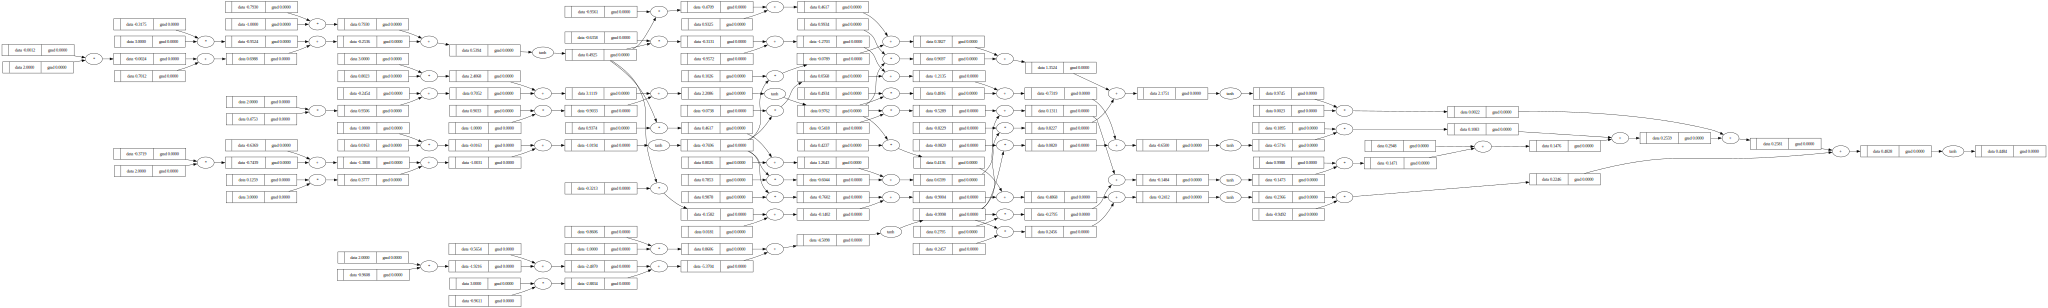

In [39]:
draw_dot(n(x))

With micrograd, we are now able to easily backpropagate through this mess.<br>
**Let's actually do that for a training scenario.**<br><br>First, we define an example training set with features and labels:

In [40]:
# Features/Inputs
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]

# Desired targets
ys = [1.0, -1.0, -1.0, 1.0]

# Get the NN's current prediction for xs
ypred = [n(x) for x in xs]

for i in range(len(ypred)):
    print(f'{ypred[i]}\t --> {ys[i]}')

Value(data=0.4484457497844679)	 --> 1.0
Value(data=0.6835797869668085)	 --> -1.0
Value(data=-0.4890066181780964)	 --> -1.0
Value(data=0.9233721935145033)	 --> 1.0


**The neural network doesn't perform well at this point. That is because it has not been trained yet.**<br>
We need to measure how good/bad the neural network performs to make steps towards improving its performance. 

To measure just how good/bad predictions are, **we need a loss function**.

In [41]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
print('loss:', loss.data)

loss: 3.405639047006587


As training progresses, the loss output by this loss function needs to become as low as possible.<br>
A lower loss indicates a smaller discrepancy between the predicted values and the ground-truth labels.

In [42]:
loss.backward()

In [43]:
# Example neuron weight with now calculated gradient
print(n.layers[0].neurons[0].w[0].grad) # First layer's first neuron's first weight's gradient
print(n.layers[0].neurons[0].w[0].data) # First layer's first neuron's first weight's value

3.1657504853266514
-0.0012205999844798754


In [44]:
# Weight Update with Backpropagation's gradients
for p in n.parameters(): 
    p.data += -0.01 * p.grad # Move a tiny bit in opposite direction of gradient to not overfit this single example

In [45]:
# Show updated weight
print(n.layers[0].neurons[0].w[0].data)

-0.03287810483774639


Ok. We now have a loss function to measure how well the neural network performs.<br>
The `loss` term is directly linked to the parameters, i.e. the activated weights and biases of the layers of the MLP.<br>
If we calculate the gradients, we determine the strength and direction<br>
of the changes we would need to make to all these weights and biases to *maximize* the loss.

Yes, *maximize*.

That's exactly what we don't want here.<br>
We want to *minimize* the loss. To do that, we do not add the gradients, but subtract them after scaling them by a factor of $0.01$.<br>
By moving each parameter a small amount in the opposite direction of its gradient, we lower the loss just a bit.<br>
Keeping this step along the gradient small prevents the model from overreacting to any single training example.

This process is called **gradient descent** and it is the core process at the heart of training neural networks.

*One more thing.*

Usually, the network isn't exposed just once to the dataset during training.
Instead, training has the network encounter each data point multiple times.<br>
One complete pass through the training dataset is called an **epoch**.

We can train our network now for $5$ epochs:

In [46]:
# Run epochs and show respective predictions
for t in range(5):
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
    print(f'Epoch {t}\t - Loss: {loss.data}\t - Predictions: {[y.data for y in ypred]}')

    loss.backward()
    for p in n.parameters(): 
        p.data += -0.01 * p.grad

Epoch 0	 - Loss: 2.794865490485899	 - Predictions: [0.389465006232113, 0.49168719307518943, -0.5655991426041365, 0.9090179963951852]
Epoch 1	 - Loss: 1.4281126882440753	 - Predictions: [0.24237523318167262, -0.1380604692430543, -0.6938845517661758, 0.8678221704723083]
Epoch 2	 - Loss: 0.9230393194235128	 - Predictions: [0.14188145711589098, -0.6724349178987212, -0.7935867083421373, 0.808253928861854]
Epoch 3	 - Loss: 0.7171814437886361	 - Predictions: [0.2167705829772557, -0.8279799900516586, -0.8364295667271546, 0.7823145534603788]
Epoch 4	 - Loss: 0.4490150472482478	 - Predictions: [0.3889621976730381, -0.8773646275220024, -0.8480091165043534, 0.8063322739146247]


**Congratulations, you just learned how to build and train a neural network from scratch!**

<center>Notebook by <a href="https://github.com/mk2112" target="_blank">mk2112</a>.</center>